# CNN-lytical Assignment-3
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will use CNNs in [PyTorch](https://pytorch.org/docs/stable/index.html) for image classification.

* We have been using MNIST by flattening 28$\times$28 images to 784-sized vectors.

* This time, we will classify images from the CIFAR-10 dataset - dimension is 32$\times$32.

* Much of this notebook remains the same as for Assignment 2, just minor changes would be needed and this assignment won't take long.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Note the following method to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch (CPU/CUDA).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import os
from torch.nn.init import xavier_uniform_
from torchvision import transforms

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(1337)

## Load *Dataset*
Use the [pickle file](https://drive.google.com/file/d/1_IHICOfAsT7x63VBBuN1WMh4bDqtUThp/view?usp=sharing) shared for this assignment here.

In [2]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load the data set
train_data_path = "/content/drive/MyDrive/CNN-lytical/CIFAR-10/train_cifar.pkl"
with open(train_data_path, 'rb') as train_data_pickle:
  train_data = pickle.load(train_data_pickle)

In [4]:
# print the shapes of the data
print(train_data['X'].shape)
print(train_data['y'].shape)

(50000, 32, 32, 3)
(50000, 1)


In [5]:
# load the data set
X = np.array(train_data['X'], dtype=np.float32)
y = np.squeeze(train_data['y'])
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(X, y):
  X_train, y_train = X[train_index], y[train_index]
  X_test, y_test = X[test_index], y[test_index]

# Print shapes
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (40000, 32, 32, 3)
y_train: (40000,)
X_test: (10000, 32, 32, 3)
y_test: (10000,)


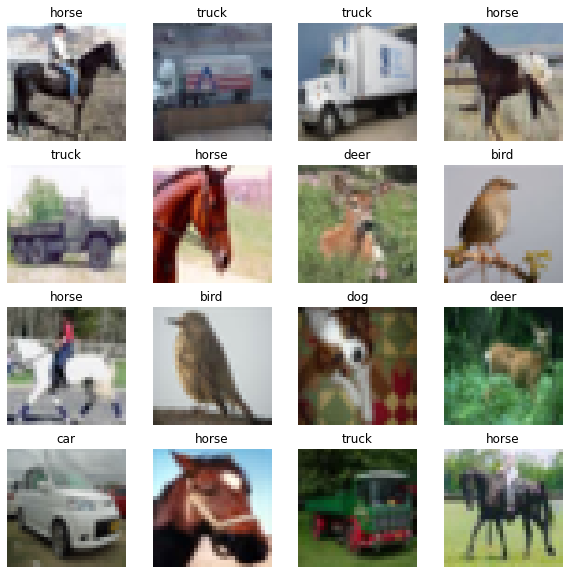

In [6]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
fig, ax = plt.subplots(4, 4, figsize=(10,10))
for i in range(1, 17):
  plt.subplot(4, 4, i)
  idx = np.random.randint(X_train.shape[0])
  plt.title(classes[y_train[idx].item()])
  plt.axis('off')
  plt.imshow(X_train[idx].astype(int))

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

You will have to perform normalization, augmentation on the dataset here itself, have a look at [PyTorch Transforms](https://pytorch.org/vision/stable/transforms.html).

**Note -** While initializing the dataset class object, make sure you only pass the numpy arrays for images and labels. So the ```__init__``` function should look like
```
    def __init__(self, X, y):
```

In [7]:
# define your dataset class
class CIFAR10Dataset(Dataset):
  def __init__(self, X, y, train=False):
    self.X = torch.from_numpy(X.transpose([0, 3, 1, 2]))
    self.y = torch.from_numpy(y)
    self.train = train
    # self.transform = transforms.Compose([
    #                                      transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5)),
    #                                      transforms.ColorJitter(hue=.05, saturation=.05),
    #                                      transforms.RandomHorizontalFlip(),
    #                                      transforms.RandomVerticalFlip()
    #                                      ])
    self.transform = transforms.Normalize((127.5, 127.5, 127.5), (127.5, 127.5, 127.5))
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # self.X.to(device)
    # self.y.to(device)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    # if self.train:
    #   return [self.transform(self.X[idx]), self.y[idx]]
    # else:
    #   return [self.X[idx], self.y[idx]]
    return [self.transform(self.X[idx]), self.y[idx]]

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers beyond those you used in the second assignment and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Conv2d```](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- [```nn.BatchNorm2d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html)


In [8]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class Net(nn.Module):
  #LeNet architecture
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # self.conv1.to(device)
    # self.pool.to(device)
    # self.conv2.to(device)
    # self.fc1.to(device)
    # self.fc2.to(device)
    # self.fc3.to(device)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [9]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    model.train()

    for data, target in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [10]:
def init_weights(model):
    xavier_uniform_(model.conv1.weight)
    xavier_uniform_(model.conv2.weight)
    xavier_uniform_(model.fc1.weight)
    xavier_uniform_(model.fc2.weight)
    xavier_uniform_(model.fc3.weight)

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [11]:
def predict(model, test_loader):
    model.eval()
    pred = None
    with torch.no_grad():
      for data, target in test_loader:
        output = model(data)
        if pred == None:
          pred = output.argmax(dim=1, keepdims=True)
          continue
        pred = torch.stack((pred, output.argmax(dim=1, keepdims=True)))
    return torch.squeeze(pred)

In [12]:
def accuracy(pred, labels):
    return (pred == labels).sum() / labels.shape[0]

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [13]:
set_seed(1337)

model = Net()
train_dataset = CIFAR10Dataset(X_train, y_train, train=True)
test_dataset = CIFAR10Dataset(X_test, y_test, train=False)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

init_weights(model)

# if torch.cuda.is_available():
#   print("CUDA available!")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)
# model.to(device)
# criterion.to(device)

In [14]:
for epoch in range(50):
  train(model, optimizer, criterion, train_loader)
  if (epoch+1)%5 == 0:
    print("Epoch: {}".format(epoch+1)) 

Epoch: 5
Epoch: 10
Epoch: 15
Epoch: 20
Epoch: 25
Epoch: 30
Epoch: 35
Epoch: 40
Epoch: 45
Epoch: 50


In [15]:
train_loader = DataLoader(train_dataset, batch_size=train_dataset.__len__(), shuffle=False)
print(accuracy(predict(model, train_loader), torch.from_numpy(y_train)))

tensor(0.7464)


## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [16]:
test_loader = DataLoader(test_dataset, batch_size=test_dataset.__len__(), shuffle=False)

print(accuracy(predict(model, test_loader), torch.from_numpy(y_test)))

tensor(0.6051)


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Also create a file ```dataset.py``` with the dataset class and all necessary imports. Other than this, save the trained model in a file named ```ass_3.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py```, ```dataset.py``` class files and the ```ass_3.pt``` model-weights file to the repository.

In [17]:
final_model = model

In [18]:
from google.colab import files
torch.save(final_model, 'ass_3.pt')
files.download('ass_3.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!